In [79]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import umap

from cryo_sbi import CryoEmSimulator
import cryo_sbi.inference.train_npe_model as train_npe_model
import cryo_sbi.utils.estimator_utils as est_utils
import cryo_sbi.utils.image_utils as img_utils

### Make the models 

Here we are creating a simple molecular model. 
In our model we will have two pseudo atoms with an unknown distance between them. 
The goal is then to simulate cryo-EM images with these models and infer the distance between the two atoms from the images.

The first step is to create the model. We start by crating an array with the distances `distance_centers` between the atoms. We will use this array to create the models.
The models are then created by placing the atom centers along the y-axis at the given distances. The x and z coordinates are set to zero.

The models are saved into teh file `models.pt`.



In [80]:
side_lengths = torch.linspace(0, 50, 100)

models = []
for side_length in side_lengths:
    model = [
        [side_length, -side_length, side_length, -side_length],
        [side_length, side_length, -side_length, -side_length],
        [0.0, 0.0, 0.0, 0.0],
    ]
    models.append(model)
models = torch.tensor(models)

##### Visualize the models

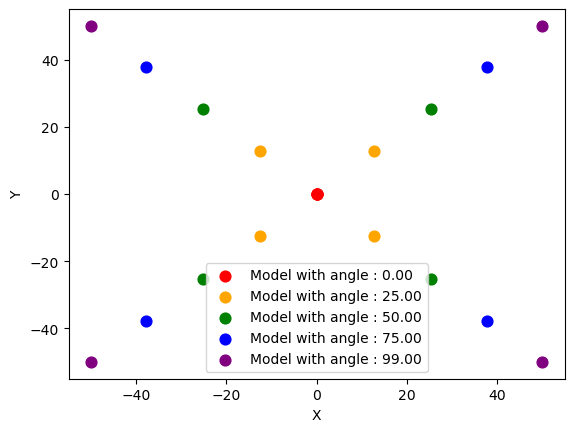

In [81]:
fig = plt.figure()
ax = fig.add_subplot()
for i, c in zip([0, 25, 50, 75, 99], ["red", "orange", "green", "blue", "purple"]):
    ax.scatter(
        models[i, 0, 0],
        models[i, 1, 0],
        s=60,
        color=c,
        label=f"Model with angle : {i:.2f}",
    )
    ax.scatter(models[i, 0, 1], models[i, 1, 1], s=60, color=c)
    ax.scatter(models[i, 0, 2], models[i, 1, 2], s=60, color=c)
    ax.scatter(models[i, 0, 3], models[i, 1, 3], s=60, color=c)

ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.legend()

In [82]:
# substract of center of mass
for i in range(100):
    models[i] = models[i] - models[i].mean(dim=1, keepdim=True)

torch.save(models, "models.pt")

### Run first simulation

We will now simulate the cryo-EM images with our generated models.
The simulation is done by the class `CryoEmSimulator`. And the simulation is run by the function `simulate` function.
The class `CryoEmSimulator` takes as input a config file with the simulation parameters. The config file used here is `simulation_parameters.json`.

The following parameters are used in the simulation:

```
simulation_parameters.json

{
    "N_PIXELS": 64,             --> size of the image
    "PIXEL_SIZE": 2.0,          --> pixel size in angstroms
    "SIGMA": [2.0, 2.0],        --> standard deviation of the gaussian
    "MODEL_FILE": "models.pt",  --> file which contains the models
    "SHIFT": 0.0,               --> shift of model center 
    "DEFOCUS": [2.0, 2.0],      --> defocus range for the simulation
    "SNR": [0.01, 0.5],         --> signal to noise ratio  for the simulation
    "AMP": 0.1,                 --> amplitude for the ctf 
    "B_FACTOR": [1.0, 1.0]      --> b factor for the ctf
} 
```

In [83]:
simulator = CryoEmSimulator(
    "simulation_parameters.json"
)  # creating simulator with simulation parameters

In [84]:
images, parameters = simulator.simulate(
    num_sim=5000, return_parameters=True
)  # simulating images and save parameters

In [85]:
dist = parameters[0]  # extracting distance from parameters
snr = parameters[-1]  # extracting snr from parameters

#### Visualize the simulated images

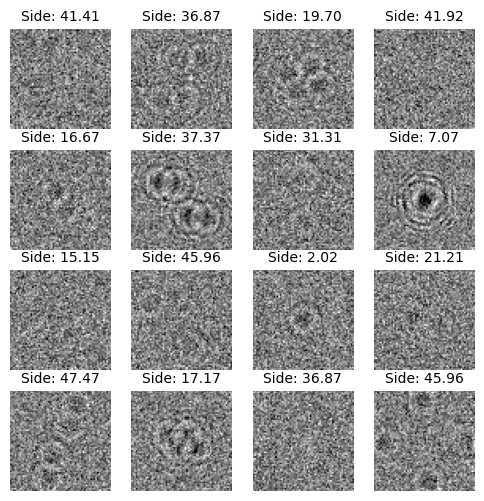

In [86]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(images[idx], vmin=-3, vmax=3, cmap="gray")
    ax.set_title(
        f"Side: {side_lengths[dist[idx].round().long()].item():.2f}", fontsize=10
    )
    ax.axis("off")

### Train cryoSBI posterior

We will now train the cryoSBI posterior to infer the distance between the atoms from the simulated images.
The training is done with the function `npe_train_no_saving` which simulates images and simultaneously trains the posterior.
The function takes as input the config file `training_parameters.json` which contains the training and neural network parameters.
The function also takes as input the config file `simulation_parameters.json` which contains the simulation parameters used to simulate the images.


```
training_parameters.json
```

```
{
    "EMBEDDING": "ConvEncoder_Tutorial",    --> embedding network for the images
    "OUT_DIM": 128,                         --> dimension of the embedding
    "NUM_TRANSFORM": 5,                     --> number of transformations
    "NUM_HIDDEN_FLOW": 5,                   --> number of hidden layers in the flow
    "HIDDEN_DIM_FLOW": 128,                 --> dimension of the hidden layers in the flow
    "MODEL": "NSF",                         --> type of flow
    "LEARNING_RATE": 0.0003,                --> learning rate
    "CLIP_GRADIENT": 5.0,                   --> gradient clipping
    "THETA_SHIFT": 50,                      --> shift of the model center
    "THETA_SCALE": 50,                      --> scale of the model
    "BATCH_SIZE": 32                        --> batch size
}
```


In [87]:
train_npe_model.npe_train_no_saving(
    "simulation_parameters.json",
    "training_parameters.json",
    150,
    "tutorial_estimator.pt",  # name of the estimator file
    "tutorial.loss",  # name of the loss file
    n_workers=4,  # number of workers for data loading
    device="cuda",  # device to use for training and simulation
    saving_frequency=100,  # frequency of saving the model
    simulation_batch_size=160,  # batch size for simulation
)

Training neural netowrk:


100%|██████████| 150/150 [10:23<00:00,  4.16s/epoch, loss=-1.83]


##### Visualize the loss after training

Text(0, 0.5, 'Loss')

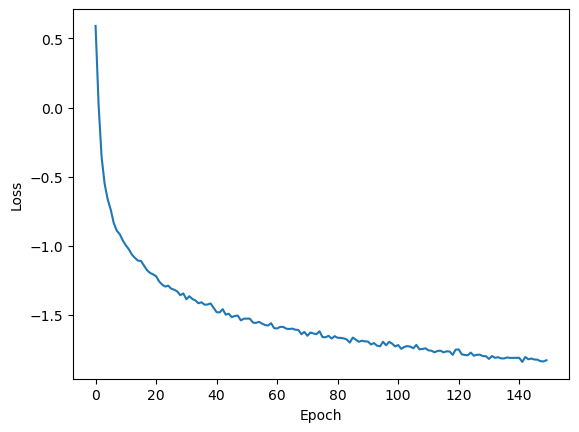

In [88]:
plt.plot(torch.load("tutorial.loss"))
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Evaluate the posterior on our simulated images

We will now evaluate the trained posterior on our simulated images.
For each simulated image we will infer the distance between the atoms and compare it to the true distance, by sampling from the posterior.

In [89]:
posterior = est_utils.load_estimator(
    "training_parameters.json",
    "tutorial_estimator.pt",
    device="cuda",
)

In [90]:
samples = est_utils.sample_posterior(
    estimator=posterior,
    images=images,
    num_samples=15000,
    batch_size=1000,
    device="cuda",
)

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


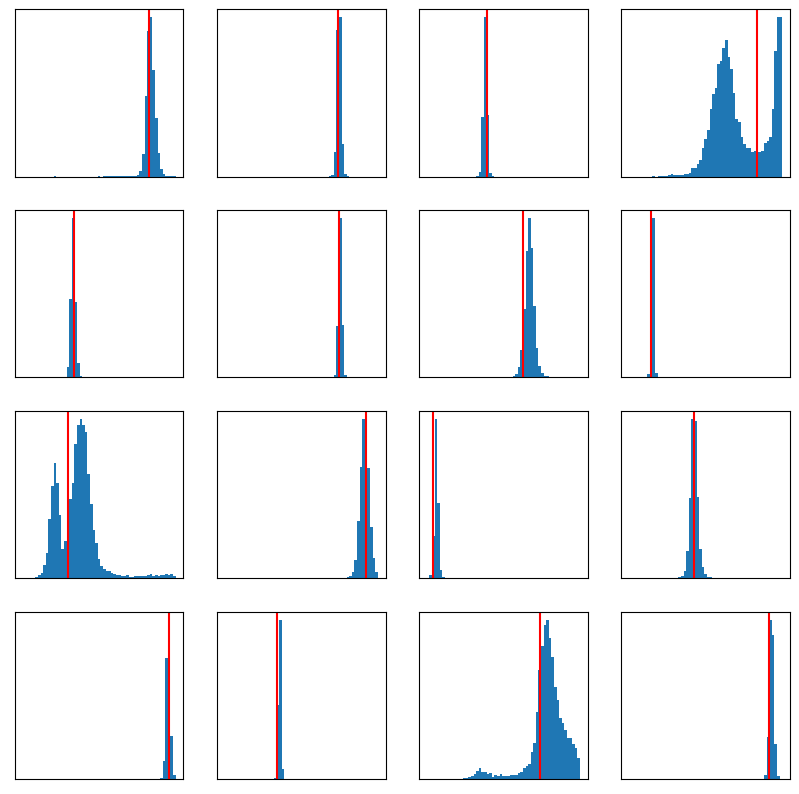

In [91]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for idx, ax in enumerate(axes.flatten()):
    ax.hist(samples[:, idx].flatten(), bins=np.linspace(0, simulator.max_index, 60))
    ax.axvline(dist[idx], ymax=1, ymin=0, color="red")
    ax.set_yticks([])
    ax.set_xticks([])

### Plot latent space

In [92]:
latent_representations = est_utils.compute_latent_repr(
    estimator=posterior,
    images=images,
    batch_size=1000,
    device="cuda",
)

In [93]:
reducer = umap.UMAP(metric="euclidean", n_components=2, n_neighbors=50)
latent_vecs_transformed = reducer.fit_transform(latent_representations.numpy())

Text(0, 0.5, 'UMAP 2')

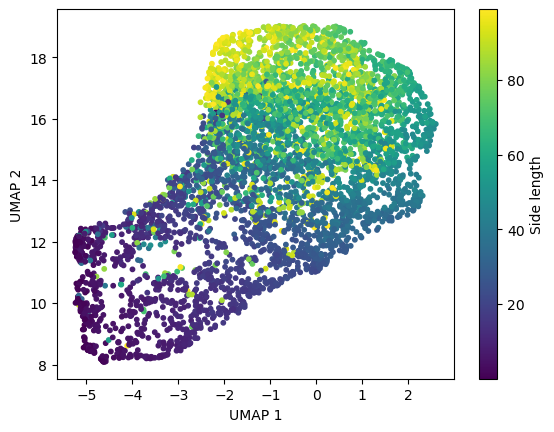

In [94]:
plt.scatter(
    latent_vecs_transformed[:, 0],
    latent_vecs_transformed[:, 1],
    c=dist,
    cmap="viridis",
    s=10,
)
plt.colorbar(label="Side length")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

Text(0, 0.5, 'UMAP 2')

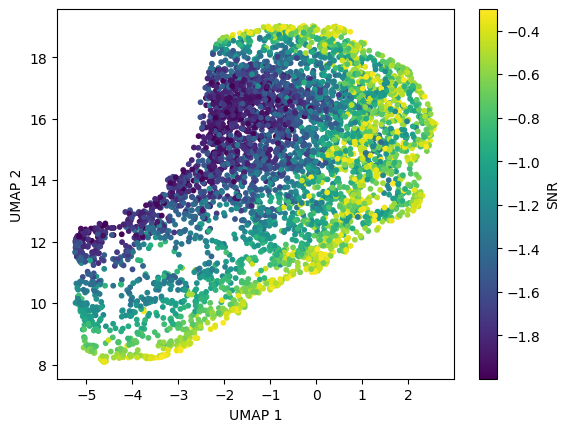

In [95]:
plt.scatter(
    latent_vecs_transformed[:, 0],
    latent_vecs_transformed[:, 1],
    c=snr,
    cmap="viridis",
    s=10,
)
plt.colorbar(label="SNR")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")